In [1]:
# THis will be the first system where I actually train the real brain with RL
# The traces will actually be fake at first, to get initial non-zero probabilities for the relevant actions
# That will be repeated for other 'custom actions' when I need it

In [2]:
from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
from RL_helper import symbol_action_map

In [4]:
game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings) # kind of a waste; will only call this object to generate random versions of itself

In [5]:
G2 = discreteGame(G.random_bare_settings(gameSize=224, max_agent_offset=0.5))

In [6]:
import matplotlib.pyplot as plt

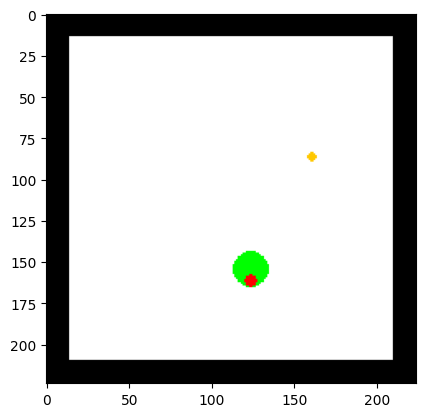

In [7]:
#G2.settings.direction = 0
#G2.universal_update()
plt.imshow(G2.getData())

In [8]:
G2.settings.__dict__

{'gameSize': 224,
 'direction': 0.05670740556368895,
 'agent_x': 0.6955103525640021,
 'agent_y': 0.5549756972828044,
 'agent_r': 0.05,
 'gold_r': 0.015625,
 'gold': [(0.39169737212800115, 0.7217502499970366)],
 'walls': [[0, 0, 0.0625, 1.0, 0],
  [0, 0, 1.0, 0.0625, 0],
  [0, 0.9375, 1.0, 0.0625, 0],
  [0.9375, 0, 0.0625, 1.0, 0]]}

In [9]:
G2.direction_angle(G2.settings.agent_x, G2.settings.agent_y, G2.settings.gold[0][0], G2.settings.gold[0][1])

2.639565004380867

In [10]:
# checks if you will intersect the gold by moving forward only
# does not check walls or anything
def will_intersect_forward(G):
    gx, gy = G.settings.gold[0]
    ax, ay = G.settings.agent_x, G.settings.agent_y
    # turns the gold into the agent's field of reference; 
    # then, check if it's in front of you and within the line you'll sweep while moving forward
    rel_gx, rel_gy = G.backRot(gx-ax, gy-ay, G.settings.direction)
    #print(rel_gx)
    #print(rel_gy)
    return (rel_gx > 0) and (abs(rel_gy) < G.settings.agent_r)

In [11]:
will_intersect_forward(G2)

False

In [12]:
import math
-1 % (2 * math.pi)

5.283185307179586

In [13]:
import math
tau = 2*math.pi

# True if the shortest path is turning clockwise (for a forward trajectory)
# False if you should turn counterclockwise instead
# turning anticlockwise increases 'direction' value
# turning clockwise decreases 'direction' value
def should_turn_anticlockwise_forward(G):
    gx, gy = G.settings.gold[0]
    ax, ay = G.settings.agent_x, G.settings.agent_y
    theta = G.settings.direction
    theta_to_gold = G.direction_angle(ax, ay, gx, gy)
    cw_theta = (theta - theta_to_gold) % tau
    #print(cw_theta)
    acw_theta = (theta_to_gold - theta) % tau
    #print(acw_theta)
    return acw_theta < cw_theta

In [14]:
should_turn_anticlockwise_forward(G2)

True

In [15]:
# best move right now, bare settings
# can use this, with game, to create track to gold (moving only forward)
def best_move_forward(G):
    if will_intersect_forward(G):
        return 1 # action 1, G.stepForward
    else:
        if should_turn_anticlockwise_forward(G):
            return 4 # action 4, G.swivel_anticlock
        else:
            return 3 # action 3, G.swivel_clock

In [16]:
from copy import deepcopy

def trace_forward(settings, maxlen=1024, zeroPad=False):
    G = discreteGame(deepcopy(settings))
    reward = 0
    steps = 0
    trace = [] # can also be numpy array or something; just getting something out there
    while reward < 1e-4 and steps < maxlen:
        action = best_move_forward(G)
        trace.append(action)
        reward += G.actions[action]()
        steps += 1
    if zeroPad:
        if len(trace) < maxlen:
            trace.append(2)
            trace = trace + [0 for i in range(maxlen - len(trace))]
    return trace

In [17]:
trace = trace_forward(G2.settings)

In [18]:
trace

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 1,
 1]

In [19]:
ind = 0

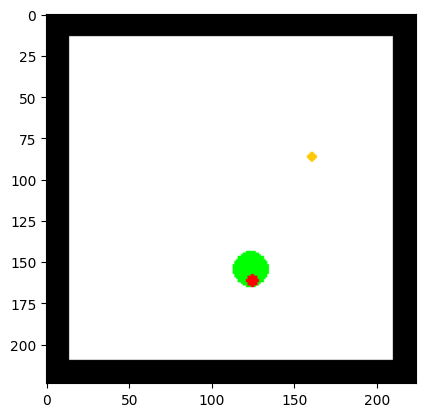

In [20]:
G2.actions[symbol_action_map[trace[ind]]]()
plt.imshow(G2.getData())
ind += 1

In [21]:
# awesome. Professional solver finished.

In [22]:
# Let's knock out one more, for fun

In [23]:
# best move right now, bare settings, both forward and backward
# can use this, with game, to create track to gold (either forward or backward)
def best_move(G):
    gx, gy = G.settings.gold[0]
    ax, ay = G.settings.agent_x, G.settings.agent_y
    # turns the gold into the agent's field of reference; 
    # then, check if it's in front of you and within the line you'll sweep while moving forward
    rel_gx, rel_gy = G.backRot(gx-ax, gy-ay, G.settings.direction)

    #print(rel_gx)
    #print(rel_gy)
    #print(G.settings.agent_r)
    if abs(rel_gy) < G.settings.agent_r:
        if rel_gx > 0:
            return 1
        else:
            return 108 # becomes '2' when decoded; this is the symbol used by the agent
    
    # if not, we have to figure out the correct angle
    theta = G.settings.direction
    back_theta = (theta + math.pi) % tau
    theta_to_gold = G.direction_angle(ax, ay, gx, gy)

    cw_theta = (theta - theta_to_gold) % tau
    cwb_theta = (back_theta - theta_to_gold) % tau
    #print(cw_theta)
    acw_theta = (theta_to_gold - theta) % tau
    acwb_theta = (theta_to_gold - back_theta) % tau

    #print(np.array([cw_theta, cwb_theta, acw_theta, acwb_theta]))
    ind = np.argmin(np.array([cw_theta, cwb_theta, acw_theta, acwb_theta]))
    #print(ind)
    if ind < 2: # cw_theta or cwb_theta
        return 3
    else:
        return 4


In [24]:
G2 = discreteGame(G.random_bare_settings(gameSize=224, max_agent_offset=0.5))

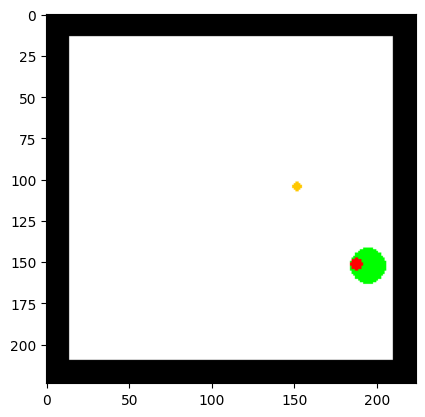

In [25]:
plt.imshow(G2.getData())

In [26]:
def trace(settings, maxlen=1024, zeroPad=False):
    G = discreteGame(deepcopy(settings))
    reward = 0
    steps = 0
    trace = [] # can also be numpy array or something; just getting something out there
    while reward < 1e-4 and steps < maxlen:
        action = best_move(G)
        trace.append(action)
        reward += G.actions[symbol_action_map[action]]()
        #print(reward)
        steps += 1
    if zeroPad:
        if len(trace) < maxlen:
            trace.append(2)
            trace = trace + [0 for i in range(maxlen - len(trace))]
    return trace

In [27]:
t2 = trace(G2.settings, maxlen=32, zeroPad=True)

In [28]:
len(t2)

32

In [29]:
t2

[3,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [30]:
t3 = trace_forward(G2.settings)

In [31]:
t3

[3, 3, 3, 3, 3, 3, 1, 1, 1, 1]

In [32]:
# From here, I will use standard cross-entropy loss and a version that has had tutorial 1, but not tutorial 2

In [33]:
# Versions using the actual GAE algorithm (but with fake traces and / or faked values) can wait until after I've made the
# naive GAE agent

In [34]:
from RL_helper import *

In [35]:
device = torch.device('cuda:0') # the 1080 by default

In [36]:
brain = DefaultAgentBrain().to(device)

In [37]:
# Need the visual stuff, but the QA stuff can wait
# I need to check on all the results of my many experiments. Full integration can wait
brain.load_state_dict(torch.load('brain_checkpoints/brain_weights_tutorial1_v3_batch95000.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [38]:
ent_criterion = nn.CrossEntropyLoss(ignore_index=0)

def get_text_loss(res, inputs):
    return torch.sum(ent_criterion(res[:, :, :-1], inputs[:, 1:]))

In [39]:
vocab_size = 10000
# tokenizer.save_model(".", "tokenizer/eng_sentences_tokenizer_vc10000")
tokenizer = ByteLevelBPETokenizer(
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-vocab.json",
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-merges.txt",
)   
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)   
tokenizer.enable_truncation(max_length=32)
tokenizer.enable_padding()

In [40]:
## Dataset
class SampleDataset(Dataset):
    def __init__(self, seq_length = 32, evaluate: bool = False, tokenizer=None, device = None):
        if device is None:
            device = 'cpu'
        self.device = device
        self.seq_length = seq_length
        if tokenizer is None:
            tokenizer = ByteLevelBPETokenizer(
                "./text_pretraining_tokenizer/eng_sentences_tokenizer_v2-vocab.json",
                "./text_pretraining_tokenizer/eng_sentences_tokenizer_v2-merges.txt",
            )   
        tokenizer._tokenizer.post_processor = BertProcessing(
            ("</s>", tokenizer.token_to_id("</s>")),
            ("<s>", tokenizer.token_to_id("<s>")),
        )   
        tokenizer.enable_truncation(max_length=self.seq_length)
        tokenizer.enable_padding()#length=seq_length)
        # or use the RobertaTokenizer from `transformers` directly.

        self.examples = []

        src_files = Path("./text_pretraining_data/").glob("*-eval.txt") if evaluate else Path("./text_pretraining_data/").glob("*-train.txt")
        for src_file in src_files:
            print("🔥", src_file)
            lines = src_file.read_text(encoding="utf-8").splitlines()
            self.examples += [x.ids for x in tokenizer.encode_batch(lines)]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i): 
        # We’ll pad at the batch level.
        return torch.tensor(self.examples[i]).to(self.device)

In [41]:
sdt = SampleDataset(tokenizer=tokenizer)
sdv = SampleDataset(tokenizer=tokenizer, evaluate=True)

🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


In [42]:
# I don't feel like writing a version that doesn't call the value function at all, right now
# I know it's slightly inefficient, but I don't care this instant
GOB = GameOutputBuffer(brain, brain.evaluate_text, gamma=0.99, tau=0.97)

In [43]:
# Just fills in the settings and the traces, nothing else
def fake_data_fill(destination_buffer, parent_game, batch_size, maxlen=32, forward_only=True):
    games = [discreteGame(parent_game.random_bare_settings(gameSize=224, max_agent_offset=0.5)) for i in range(batch_size)]
    if forward_only:
        traces = [[0] + trace_forward(G.settings, maxlen=maxlen - 1, zeroPad=True) for G in games]
    else:
        traces = [[0] + trace(G.settings, maxlen=maxlen - 1, zeroPad=True) for G in games]
    destination_buffer.settings_buffer = [[G.settings] for G in games]
    #destination_buffer.rewards = torch.zeros(device
    for b in range(batch_size):
        G = games[b]
        for val in traces[b]:
            if val in special_symbols:
                G.actions[symbol_action_map[val]] # no need to store rewards
            destination_buffer.settings_buffer[b].append(deepcopy(G.settings))
    destination_buffer.traces = torch.tensor(traces).to(device)
    destination_buffer.seed_offset = 1
    destination_buffer.logpas = torch.zeros((batch_size, maxlen-1), device=device) # to be amended
    destination_buffer.entropies = torch.zeros((batch_size, maxlen-1), device=device)
    destination_buffer.terminated, destination_buffer.past_terminated = destination_buffer.get_terminations() # only part actually used
    destination_buffer.rewards = torch.zeros((batch_size, maxlen), device=device)
    destination_buffer.returns = torch.zeros((batch_size, maxlen), device=device)
    destination_buffer.gaes = torch.zeros((batch_size, maxlen-1), device=device)
    # That *should* be everything I actually need
    return None

In [44]:
#fake_data_fill(GOB, G, 8)

In [45]:
#GOB.traces

In [46]:
#GOB.traces.size()

In [47]:
#logpas, ents = GOB.get_probabilities_and_entropies()

In [48]:
#logpas

In [49]:
#L = torch.sum(0 - logpas)

In [50]:
#L.backward()

In [51]:
# Hell yes, we have a way forward

In [52]:
# No reason to mess up the other components
optimizer = optim.Adam(brain.text_dec.parameters(), lr=0.00001, eps=1e-9)

In [ ]:
import time

total_batches = 6250*32

batch_size = 8 # perfect size for the 2080

total_loss = 0
total_task_loss = 0
total_control_loss = 0

num_controls = len(sdt)

curr_min = 1e6

for b in range(total_batches):
    if b == 0:
        start = time.time()

    fake_data_fill(GOB, G, batch_size)
    logpas, _ = GOB.get_probabilities_and_entropies()
    task_loss = 0 - torch.sum(logpas) / 1000
    task_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    ind = (b * batch_size) % num_controls
    if ind + batch_size > num_controls:
        ind = num_controls - batch_size
    control_texts = sdt[ind:ind + batch_size].to(device)
    control_images = get_images_settings([S[0] for S in GOB.settings_buffer], device=device)

    control_probs = brain(control_texts, control_images, ret_imgs=False)
    control_loss = get_text_loss(control_probs, control_texts)

    #loss = control_loss + task_loss
    control_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    total_loss += task_loss.item() + control_loss.item()
    total_task_loss += task_loss.item()
    total_control_loss += control_loss.item()

    if b == 0:
        runtime = time.time() - start
        print(f"Time for 1 batch: {runtime} seconds")
    if (b % 100 == 99):
        avg_loss = total_loss / 100
        avg_control_loss = total_control_loss / 100
        avg_task_loss = total_task_loss / 100
        
        total_loss = 0
        total_control_loss = 0
        total_task_loss = 0
        
        if avg_task_loss < curr_min:
            curr_min = avg_task_loss
            torch.save(brain.state_dict(), f'brain_checkpoints/brain_weights_RL_fake_traces_v1_batch{b + 1}.pth')

        print(f"Avg loss for last 100 batches, at batch {b + 1}: {avg_loss}:\n{avg_control_loss} control,\n{avg_task_loss} task\n\n")
        

Time for 1 batch: 4.361232280731201 seconds
Avg loss for last 100 batches, at batch 100: 3.8186962477490307:
3.1842600870132447 control,
0.634436160735786 task


